In [1]:
# default_exp control_refine

This contains code for refining the following control points:

* Checker
* Ellipse

The term "refine" is used here because an initial guess for the location is required.

# Import

In [2]:
# export
import math

import numpy as np
import skimage.draw
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

from camera_calib.utils import *

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

from camera_calib.image import File16bitImg

# Base class

I tried to make a generic control flow loop for refining control points which you can inherit and modify/implement

In [4]:
# export
class CPRefiner:
    def __init__(self, cutoff_it, cutoff_norm):
        self.cutoff_it   = cutoff_it
        self.cutoff_norm = cutoff_norm

    def proc_arr(self, arr):            return (arr,)
    def it_preproc(self, p, b):         pass
    def get_bb(self, p, b):             raise NotImplementedError('Please implement get_bb')
    def get_W(self, p, b, bb):          return None    
    def refine_point(self, arrs, p, W): raise NotImplementedError('Please implement refine_point')

    def __call__(self, arr, ps, bs):
        arrs = self.proc_arr(arr)
        bb_arr = array_bb(arr)
        ps_refined = []
        for idx, (p, b) in enumerate(zip(ps, bs)):
            self.it_preproc(p, b)
            b_init = b
            for it in torch.arange(self.cutoff_it):
                p_prev = p
                bb = self.get_bb(p, b)
                if not is_bb_in_bb(bb, bb_arr): p = arr.new_full(2, math.nan); break
                W = self.get_W(p, b, bb)
                p = self.refine_point(tuple(bb_array(arr, bb) for arr in arrs), p-bb[0], W)+bb[0] 
                if torch.any(torch.isnan(p)): break
                if not is_p_in_b(p, b_init):    p = arr.new_full(2, math.nan); break
                if torch.norm(p-p_prev) < self.cutoff_norm: break
                b = b-p_prev+p
            ps_refined.append(p)
        return stackify(tuple(ps_refined))

# Checker

In [5]:
# export
class CheckerRefiner(CPRefiner):
    def __init__(self, hw_min, hw_max, cutoff_it, cutoff_norm):
        super().__init__(cutoff_it, cutoff_norm)
        assert_allclose(type(hw_min), int)
        assert_allclose(type(hw_max), int)
        self.hw_min, self.hw_max = hw_min, hw_max

    def it_preproc(self, p, b):
        ls = [ps2l(b[idx], b[torch.remainder(idx+1, len(b))]) for idx in torch.arange(len(b))]
        d_min = stackify(tuple(pld(p, l) for l in ls)).min()
        hw = torch.floor(d_min/math.sqrt(2))
        hw = hw.clamp(self.hw_min, self.hw_max)
        self.hw = hw
        self.bb = stackify(((-hw, -hw),
                            ( hw,  hw)))

    def get_bb(self, p, b): return self.bb+p.round()

    def get_W(self, p, b, bb):
        zero = p.new_tensor(0)

        sigma = self.hw/2
        cov = stackify(((sigma**2,     zero),
                        (    zero, sigma**2)))
        d = MultivariateNormal(p, covariance_matrix=cov)
        return torch.exp(d.log_prob(grid2ps(*bb_grid(bb)))).reshape(tuple(bb_sz(bb).long()))

### Opencv method

In [6]:
# export
@numpyify
def checker_opencv(arr_dx, arr_dy, W=None):    
    # Condition array points
    ps_cond, T = condition(array_ps(arr_dx))
        
    # Form linear system 
    A = grid2ps(arr_dx, arr_dy)
    b = (A*ps_cond).sum(dim=1)
    
    # Get weighted least squares estimate
    p = wlstsq(A, b, W)
    
    # Convert back to unconditioned points
    return pmm(p, torch.inverse(T), aug=True)

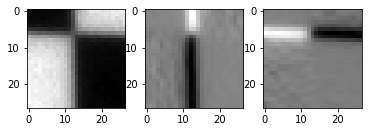

In [7]:
file_img = Path('data/dot_vision_checker/SERIAL_16276942_DATETIME_2019-06-07-00:38:48-109736_CAM_3_FRAMEID_0_COUNTER_2.png')
bb = torch.FloatTensor([[540, 965], [566, 991]])
arr = bb_array(File16bitImg(file_img).array_gs(torch.float), bb)
arr_dx, arr_dy = grad_array(arr)
fig, axs = plt.subplots(1,3)
for a, ax in zip([arr, arr_dx, arr_dy], axs): ax.imshow(a, cmap='gray')

In [8]:
p = checker_opencv(arr_dx, arr_dy)
p

tensor([11.9810,  6.2994])

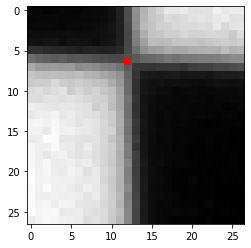

In [9]:
plt.imshow(arr, cmap='gray')
plt.plot(p[0], p[1], 'rs')

In [10]:
# export
class OpenCVCheckerRefiner(CheckerRefiner):
    def __init__(self, hw_min, hw_max, cutoff_it, cutoff_norm):
        super().__init__(hw_min, hw_max, cutoff_it, cutoff_norm)

    def proc_arr(self, arr): return grad_array(arr)

    def refine_point(self, arrs, p, W): return checker_opencv(*arrs, W)

In [11]:
refiner = OpenCVCheckerRefiner(hw_min=3, hw_max=10, cutoff_it=20, cutoff_norm=1e-3)

In [12]:
file_img = Path('data/dot_vision_checker/SERIAL_16276942_DATETIME_2019-06-07-00:38:48-109736_CAM_3_FRAMEID_0_COUNTER_2.png')
img = File16bitImg(file_img)
ps_c_p = torch.FloatTensor([[858.7428864 , 633.38643518]])
bs_c_p = torch.FloatTensor([[[878.5844935448612, 614.1667623245968],
                             [838.8941064355354, 613.1104586040717],
                             [838.9778791064288, 652.5319092059557],
                             [878.5655638183706, 653.6357474223086]]])
ps_c_p_refined = refiner(img.array_gs(torch.float), ps_c_p, bs_c_p)
assert_allclose(ps_c_p_refined, torch.FloatTensor([[860.234, 635.174]]), atol=1e-3)

(620.0, 650.0)

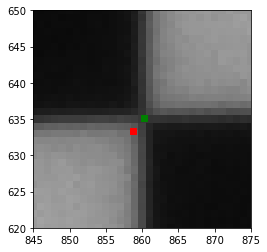

In [13]:
plt.imshow(img.array_gs(torch.float), cmap='gray')
plt.plot(ps_c_p[:,0], ps_c_p[:,1], 'rs')
plt.plot(ps_c_p_refined[:,0], ps_c_p_refined[:,1], 'gs')
plt.gca().set_xlim(845, 875)
plt.gca().set_ylim(620, 650)

# Ellipse

Note that torch doesnt have a `polygon2mask` function, so just convert to numpy and then back to tensor for now

In [14]:
# export
class EllipseRefiner(CPRefiner):
    def __init__(self, cutoff_it, cutoff_norm):
        super().__init__(cutoff_it, cutoff_norm)

    def it_preproc(self, p, b):
        bb = ps_bb(b)
        bb = stackify((bb[0].floor(), bb[1].ceil()))
        W = p.new_tensor(skimage.draw.polygon2mask(*torch2np((tuple(bb_sz(bb).long()), b-bb[0]))))
        self.bb, self.W = bb-p.round(), W

    def get_bb(self, p, b):    return self.bb+p.round()
        
    def get_W(self, p, b, bb): return self.W

### dual conic method

In [15]:
# export
@numpyify
def fit_conic(arr_dx, arr_dy, W=None):   
    one = arr_dx.new_tensor(1)
    
    # Condition array points
    ps_cond, T = condition(array_ps(arr_dx))
        
    # Form homogeneous coordinates of lines
    ls = grid2ps(arr_dx, arr_dy)
    ls = torch.cat([ls, -(ls*ps_cond).sum(dim=1, keepdim=True)], dim=1)
    
    # Form linear system 
    A = stackify((ls[:,0]**2, ls[:,0]*ls[:,1], ls[:,1]**2, ls[:,0]*ls[:,2], ls[:,1]*ls[:,2]), dim=1)
    b = -ls[:, 2]**2
        
    # Get weighted least squares estimate
    aq_inv = wlstsq(A, b, W)
    
    # Get conic matrix
    Aq_inv = stackify(((  aq_inv[0], aq_inv[1]/2, aq_inv[3]/2),
                       (aq_inv[1]/2,   aq_inv[2], aq_inv[4]/2),
                       (aq_inv[3]/2, aq_inv[4]/2,         one)))
    Aq = torch.inverse(Aq_inv)

    # Rescale conic matrix to take conditioning into account
    return T.T@Aq@T

In [16]:
# export
@numpyify
def ellipse_dualconic(arr_dx, arr_dy, W=None):
    Aq = fit_conic(arr_dx, arr_dy, W)
    return conic2ellipse(Aq)

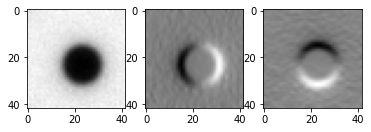

In [17]:
file_img = Path('data/dot_vision_circle/SERIAL_19061245_DATETIME_2020-05-17-20:48:11-005188_CAM_1_FRAMEID_0_COUNTER_1.png')
bb = torch.FloatTensor([[520, 975], [561, 1016]])
arr = bb_array(File16bitImg(file_img).array_gs(torch.float), bb)
arr_dx, arr_dy = grad_array(arr)
fig, axs = plt.subplots(1,3)
for a, ax in zip([arr, arr_dx, arr_dy], axs): ax.imshow(a, cmap='gray')

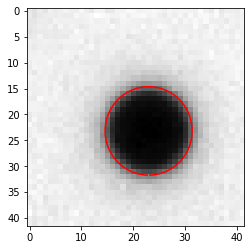

In [18]:
e = ellipse_dualconic(arr_dx, arr_dy)
ps_e = sample_ellipse(e, 100)
plt.imshow(arr, cmap='gray')
plt.plot(ps_e[:,0], ps_e[:,1],'-r')

In [19]:
# export
class DualConicEllipseRefiner(EllipseRefiner):    
    def __init__(self, cutoff_it, cutoff_norm):
        super().__init__(cutoff_it, cutoff_norm)
        
    def proc_arr(self, arr): return grad_array(arr)
    
    def refine_point(self, arrs, p, W): return ellipse_dualconic(*arrs, W)[:2]

In [20]:
refiner = DualConicEllipseRefiner(cutoff_it=20, cutoff_norm=1e-3)

In [21]:
file_img = Path('data/dot_vision_circle/SERIAL_19061245_DATETIME_2020-05-17-20:48:11-005188_CAM_1_FRAMEID_0_COUNTER_1.png')
img = File16bitImg(file_img)
ps_c_p = torch.FloatTensor([[ 89.74539133, 996.88665043]])
bs_c_p = torch.FloatTensor([[[ 89.5465538485512, 1029.648805759194],
                             [ 57.6381616678298,  996.914281777708],
                             [ 89.9441082645408,  964.144356548655],
                             [121.8893325612110,  996.858987492743]]])
ps_c_p_refined = refiner(img.array_gs(torch.float), ps_c_p, bs_c_p)
assert_allclose(ps_c_p_refined, torch.FloatTensor([[ 95.89870615, 997.13709847]]))

(982.0, 1012.0)

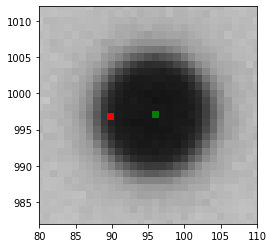

In [22]:
plt.imshow(img.array_gs(torch.float), cmap='gray')
plt.plot(ps_c_p[:,0], ps_c_p[:,1], 'rs')
plt.plot(ps_c_p_refined[:,0], ps_c_p_refined[:,1], 'gs')
plt.gca().set_xlim(80,  110)
plt.gca().set_ylim(982, 1012)

# Build

In [23]:
build_notebook()

<IPython.core.display.Javascript object>

Converted control_refine.ipynb.
